### Introduction ###

L'objectif est de comprendre comment les différents modèles de réseaux neuronaux peuvent reconnaître des images en apprenant sur un grand ensemble d'entraînement et de tests aléatoires, ainsi que leur structure interne.

Ce projet présente des architectures de réseaux neuronaux classiques telles que VGG, AlexNet et ResNet que j'ai étudiées. En modifiant les couches ou les paramètres d'entraînement du modèle, j'ai proposé des architectures adaptées à des images RGB d'entrée de 32 * 32, dans le but d'augmenter la précision du modèle dans les contraintes données. J'ai appris sur l'ensemble des données à l'aide de l'ensemble de test et de l'ensemble d'entraînement via CIFAR10, et j'ai enregistré les résultats pour chaque itération. Ensuite, j'ai comparé leurs performances en termes de nombre de paramètres, de temps d'entraînement, de nombre d'opérations d'entraînement, d'opérations d'entraînement par seconde et de précision.

Ensuite, j'ai amélioré le meilleur système en testant différentes variantes, notamment les blocs résiduels, la décroissance des poids, les taux d'apprentissage et la taille des lots, puis j'ai évalué les performances en comparant la durée d'exécution et la précision après les changements.

Enfin, j'ai analysé les meilleurs systèmes contenant les meilleures variantes par catégorie pour évaluer plus précisément les performances du meilleur système dans différentes catégories, en utilisant le machine learning pour visualiser les mesures de chaque catégorie afin de comparer de manière plus intuitive les performances du modèle pour différentes catégories. Enfin, j'ai évalué mon modèle entraîné par des images aléatoires afin de déterminer si sa prédiction est fiable ou non. Grâce à ces analyses, j'ai pu mieux comprendre toutes les étapes des tests de formation pour les réseaux neuronaux et évaluer l'adéquation et la performance de différentes architectures de réseaux neuronaux pour des tâches spécifiques.

### Imports ###

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Running on GPU ###

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Hyperparameters ###

In [3]:
BATCH_SIZE = 128

### Dataset ###

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Réseau neuronal original

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def count_maxpool_operations(self, input, output, pool_layer, out_channels):
        kernel_maxpooling = pool_layer.kernel_size
        stride = pool_layer.stride
        padding = pool_layer.padding
        output_height = output.shape[2]
        output_width = output.shape[3]
        out_channels =  output.shape[1]
        num_max = output_height * output_width * (kernel_maxpooling**2 -1) * out_channels
        return num_max

    def count_conv_operations(self, input, output, output_pooled, conv_layer, pool_layer):
        out_channels, in_channels = output.size(1), conv_layer.in_channels
        output_height, output_width = output.size(2), output.size(3)
        filter_size = conv_layer.kernel_size[0]
        stride = conv_layer.stride[0]
        padding = conv_layer.padding[0]
        num_mults = output_height * output_width * in_channels * filter_size ** 2 * out_channels
        num_adds = output_height * output_width * in_channels * filter_size ** 2 * out_channels
        num_maxs = self.count_maxpool_operations(output, output_pooled, pool_layer, out_channels)
        total_ops = num_mults + num_adds + num_maxs
        return num_mults, num_adds, num_maxs, total_ops

    def count_operations(self, x):
        conv1_out = self.conv1(x)
        conv1_out_pooled = self.pool(F.relu(conv1_out))
        conv2_out = self.conv2(conv1_out_pooled)
        conv2_out_pooled = self.pool(F.relu(conv2_out))
        conv1_ops = self.count_conv_operations(x, conv1_out, conv1_out_pooled, self.conv1, self.pool)
        conv2_ops = self.count_conv_operations(conv1_out_pooled, conv2_out, conv2_out_pooled, self.conv2, self.pool)
        return conv1_ops, conv2_ops        

    def count_fc_operations(self, input, fc_layer):
        in_features = fc_layer.in_features
        out_features = fc_layer.out_features
        num_mults = out_features * in_features
        num_adds = out_features * in_features
        num_maxs = 0    
        total_ops = num_mults + num_adds
        return num_mults, num_adds, num_maxs, total_ops

    def count_total_operations(self, x):
        conv1_ops, conv2_ops = self.count_operations(x)
        fc1_ops = self.count_fc_operations(x, self.fc1)
        fc2_ops = self.count_fc_operations(x, self.fc2)
        fc3_ops = self.count_fc_operations(x, self.fc3)
        total_ops = sum(op[3] for op in [conv1_ops, conv2_ops, fc1_ops, fc2_ops, fc3_ops])
        return total_ops


### Dans la partie entraînement du réseau CNN, lister les différentes couches et sous-couches :
1. **2 couches de convolution :**
   - `self.conv1`: Première couche de convolution avec 3 canaux d'entrée et 6 canaux de sortie, utilisant un noyau de taille 5x5.
   - `self.conv2`: Deuxième couche de convolution avec 6 canaux d'entrée et 16 canaux de sortie, également avec un noyau de taille 5x5.

   - **2 sous-couche non linéaire :** Après chaque opération de convolution, une activation ReLU est appliquée.

2. **2 couches de max pooling :**

   - `self.pool`: Utilisé après chaque couche de convolution pour réduire la dimensionnalité de la sortie.

3. **3 couches entièrement connectées :**
   - `self.fc1`: Première couche entièrement connectée avec 16*5*5 entrées et 120 sorties.
   - `self.fc2`: Deuxième couche entièrement connectée avec 120 entrées et 84 sorties.
   - `self.fc3`: Troisième couche entièrement connectée avec 84 entrées et 10 sorties.

   - **3 sous-couche linéaire :** Chaque couche entièrement connectée effectue une transformation linéaire des caractéristiques d'entrée.
   - **2 sous-couche non linéaire :** Après chaque transformation linéaire, une activation ReLU est appliquée, introduisant de la non-linéarité.
  
4. **4 sous-couches Relu**

In [6]:
net = Net().to(device)
for p in net.parameters(): print(p.size())

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


### Donner la taille des différents tenseurs de données Xn et de poids Wn le long du calcul: ###

1. **Convolutional Layer 1 (conv1):**
- X1 = [3, 32, 32]
- Poids W1:
    - Poids de convolution: torch.Size([6, 3, 5, 5])
    - Bias: torch.Size([6])

2. **Convolutional Layer 2 (conv2):**
    - X2 = [6, 14, 14]
- Poids W2:
    - Poids de convolution: torch.Size([16, 6, 5, 5])
    - Bias: torch.Size([16])

3. **Fully Connected Layer 1 (fc1):**
- X3: [400]
- Poids W3:
    - Poids de linéaire: torch.Size([120, 400])
    - Bias: torch.Size([120])

4. **Fully Connected Layer 2 (fc2):**
- X4: [120]
- Poids W4:
    - Poids de linéaire: torch.Size([84, 120])
    - Bias: torch.Size([84])
  
5. **Fully Connected Layer 3 (fc3):**
- X5: [84]
- Poids W5:
    - Poids de linéaire: torch.Size([10, 84])
    - Bias: torch.Size([10])

## Model Residual Net ##

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        inchannel = 64 
        for stride in strides:
            layers.append(block(inchannel, channels, stride))
            inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = F.avg_pool2d(out, 8)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

    def count_conv_operations(self, input, output, output_pooled, stride, padding, kernel_size):
        out_channels = output.size(1)
        output_height, output_width = output.size(2), output.size(3)
        num_mults = output_height * output_width * input.size(1) * kernel_size ** 2 * out_channels
        num_adds = output_height * output_width * input.size(1) * kernel_size ** 2 * out_channels
        num_maxs = self.count_maxpool_operations(output, output_pooled)
        total_ops = num_mults + num_adds + num_maxs
        return num_mults, num_adds, num_maxs, total_ops

    def count_maxpool_operations(self, output, output_pooled):
        kernel_size = 2 
        stride = 2 
        padding = 0
        output_height = output.shape[2]
        output_width = output.shape[3]
        out_channels = output.shape[1]
        num_max = ((output_height + 2 * padding - kernel_size) // stride + 1) * ((output_width + 2 * padding - kernel_size) // stride + 1) * (kernel_size ** 2 - 1) * out_channels
        return num_max

    def count_fc_operations(self, input, fc_layer):
        in_features = fc_layer.in_features
        out_features = fc_layer.out_features    
        num_mults = out_features * in_features
        num_adds = out_features * in_features
        num_maxs = 0
        total_ops = num_mults + num_adds
        return num_mults, num_adds, num_maxs, total_ops

    def count_total_operations(self, x):
        conv1_out = self.conv1(x)
        conv1_out_pooled = self.relu(self.bn1(conv1_out))
        conv1_ops = self.count_conv_operations(x, conv1_out, conv1_out_pooled, self.conv1, None, kernel_size=3)

        layer1_out = self.layer1(conv1_out_pooled)
        layer1_out_pooled = F.avg_pool2d(layer1_out, 8)
        layer1_ops = self.count_conv_operations(conv1_out_pooled, layer1_out, layer1_out_pooled, stride=1, padding=1, kernel_size=3)

        fc_ops = self.count_fc_operations(x, self.fc)

        total_ops = sum(op[3] for op in [conv1_ops, layer1_ops, fc_ops])
        return total_ops

[2, 2] signifie qu'il y a 2 répétitions d'unités résiduelles dans le bloc résiduel et ensuite 2 répétitions de ce bloc résiduel.

In [9]:
def ResNet_2x2():
    return ResNet(ResidualBlock, [2, 2])

In [10]:
netRes = ResNet_2x2().to(device)
netRes.eval()
netRes.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

**1. Le nombre de couches et sous-couches de Residual Net avec ResidualBlock [2,2]:**
- **9 couches de convolution**:
Dans ce cas **[2, 2]**, la fonction ResNet_2x2 renvoie un modèle ResNet comprenant 2 répétitions d'unités résiduelles dans chaque bloc résiduel, et ensuite 2 répétitions de ce bloc résiduel. Par conséquent, il y a un total de 4 blocs résiduels. Chaque bloc résiduel contient 2 couches de convolution. De plus, dans le modèle ResNet, il y a une couche de convolution initiale `self.conv1`. Ainsi, il y a en tout 1 + 4 * 2 = 9 couches de convolution.
  
- **9 couches de Batch Normalization**: 
Chaque bloc résiduel contient 2 couches de Batch Normalization, donc avec 4 blocs résiduels, il y a au total 2 * 4 = 8 couches de Batch Normalization. Ajoutant la couche de Batch Normalization utilisée après la première couche de convolution, cela donne un total de 8 + 1 = 9 couches de Batch Normalization.

- **8 couches ReLU**: Chaque bloc résiduel contient 2 sous-couches ReLU, une après chaque opération de convolution. Comme il y a 4 blocs résiduels dans ResNet_2x2 **[2, 2]**, cela fait un total de 4 * 2 = 8 sous-couches ReLU.

- **4 couches shortcut**: Chaque bloc résiduel contient 1 couche de shortcut, donc avec quatre blocs résiduels, il y a au total 1 * 4 = 4 couches de shortcut.
  
- **1 couche entièrement connectée**
- **1 sous-couche de Average Pooling**

[3, 2] signifie qu'il y a 3 répétitions d'unités résiduelles dans le bloc résiduel et ensuite 2 répétitions de ce bloc résiduel.

In [11]:
def ResNet_3x2():
    return ResNet(ResidualBlock, [3, 2])

In [12]:
netRes = ResNet_3x2().to(device)
netRes.eval()
netRes.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

**1. Le nombre de couches et sous-couches de Residual Net avec ResidualBlock [3,2]:**
- **13 couches de convolution**:
Dans ce cas **[3, 2]**, La fonction ResNet_3x2 renvoie un modèle ResNet. Chaque bloc résiduel comporte 2 répétitions d'unités résiduelles, et il y a 3 répétitions de ce bloc résiduel, donc il y a un total de 6 unités résiduelles dans le modèle. Chaque bloc résiduel contient 2 couches de convolution. De plus, dans le modèle ResNet, il y a une couche de convolution initiale `self.conv1`. Ainsi, le modèle comprend 1 + 6 * 2 = 13 couches de convolution.
  
- **13 couches de Batch Normalization**: 
Chaque bloc résiduel contient deux couches de Batch Normalization, donc avec 6 blocs résiduels, il y a au total 2 * 6 = 12 couches de Batch Normalization. Ajoutant la couche de Batch Normalization utilisée après la première couche de convolution, cela donne un total de 12 + 1 = 13 couches de Batch Normalization.

- **12 couches ReLU**: Chaque bloc résiduel contient 2 sous-couches ReLU, une après chaque opération de convolution. Comme il y a 6 blocs résiduels dans ResNet_3x2 **[3, 2]**, cela fait un total de 6 * 2 = 12 sous-couches ReLU.

- **6 couches shortcut**: Chaque bloc résiduel contient une couche de shortcut, donc avec 6 blocs résiduels, il y a au total 1 * 6 = 6 couches de shortcut.
  
- **1 couche entièrement connectée**
- **1 sous-couche de Average Pooling**

In [13]:
netRes = ResNet_2x2().to(device)
for p in netRes.parameters(): print(p.size())

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([10, 1024])
torch.Size([10])


**2. identification la taille des différents tenseurs de données Xn et de poids Wn le long du calcul:**

**Données d'entrée :**
- X0: [3, 32, 32]

**Couche de convolution 1 (conv1) :**
- Données de sortie (X1) : Taille [64, 32, 32]
- Poids du filtre (W1) : Taille **[64, 3, 3, 3]**
- Biais : Taille [64]

**Couche de normalisation par lots 1 :**
- Données de sortie (X2) : Taille [64, 32, 32]

**Bloc résiduel 1 :**
- Données de sortie (X3) : Taille [64, 32, 32]
- Poids du premier filtre (W2) : Taille **[64, 64, 3, 3]**
- Biais du premier filtre: Taille [64]
- Poids du deuxième filtre (W3) : Taille **[64, 64, 3, 3]**
- Biais du deuxième filtre: Taille [64]

**Bloc résiduel 2 :**
- Données de sortie (X4) : Taille [64, 32, 32]
- Poids du premier filtre (W4) : Taille **[64, 64, 3, 3]**
- Biais du premier filtre: Taille [64]
- Poids du deuxième filtre (W5) : Taille **[64, 64, 3, 3]**
- Biais du deuxième filtre: Taille [64]

**Couche de pooling moyenne :**
- Données de sortie (X5) : Taille [64, 4, 4]

**Couche d'aplatissement :**
- Données de sortie (X6) : Taille [1024]

**Couche entièrement connectée :**
- Données de sortie (X7) : Taille [10]
- Poids du filtre (W7) : Taille **[10, 1024]**
- Biais: Taille [10]

**3. identification de toutes les fonctions successives (les “Fn”) avec leurs types:**

**Couche de convolution 1 (conv1) :**
- Type de fonction : Convolution nn.Conv2d
- Fonction d'activation : nn.ReLU
- Fonction de normalisation : nn.BatchNorm2d

**Blocs résiduels (layer1) :**
- Type de fonction : Bloc résiduel
- Fonction de convolution : nn.Conv2d
- Fonction d'activation : nn.ReLU
- Fonction de normalisation : nn.BatchNorm2d

**Couche entièrement connectée (fc) :**
- Type de fonction : nn.Linear

## Model AlexNet ##

In [14]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=48, kernel_size=3, padding=1)
        self.batchnorm = nn.BatchNorm2d(48)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        self.fc1 = nn.Linear(in_features=3*3*48, out_features=128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm(x)
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def count_maxpool_operations(self, input, output, pool_layer):
        if pool_layer:
            kernel_size = pool_layer.kernel_size
            stride = pool_layer.stride
            padding = pool_layer.padding
            output_height = output.shape[2]
            output_width = output.shape[3]
            out_channels = output.shape[1]
            num_max = ((output_height + 2 * padding - kernel_size) // stride + 1) * ((output_width + 2 * padding - kernel_size) // stride + 1) * (kernel_size ** 2 - 1) * out_channels  
        else:
            num_max = 0
        return num_max

    def count_conv_operations(self, input, output, output_pooled, conv_layer, pool_layer):
        out_channels, in_channels = output.size(1), conv_layer.in_channels
        output_height, output_width = output.size(2), output.size(3)
        filter_size = conv_layer.kernel_size[0]
        stride = conv_layer.stride[0]
        padding = conv_layer.padding[0]
        num_mults = output_height * output_width * in_channels * filter_size ** 2 * out_channels
        num_adds = output_height * output_width * in_channels * filter_size ** 2 * out_channels
        num_maxs = self.count_maxpool_operations(output, output_pooled, pool_layer)
        if pool_layer:
            num_maxs = self.count_maxpool_operations(output, output_pooled, pool_layer)
        else:
            num_maxs = 0
        total_ops = num_mults + num_adds + num_maxs
        return num_mults, num_adds, num_maxs, total_ops

    def count_operations(self, x):
        conv1_out = F.relu(self.conv1(x))
        conv1_out_pooled = self.maxpool1(conv1_out)
        conv2_out = F.relu(self.conv2(conv1_out_pooled))
        conv2_out_norm = self.batchnorm(conv2_out)
        conv2_out_pooled = self.maxpool2(conv2_out_norm)
        conv3_out = F.relu(self.conv3(conv2_out_pooled))
        conv4_out = F.relu(self.conv4(conv3_out))
        conv5_out = F.relu(self.conv5(conv4_out))
        conv5_out_pooled = self.maxpool3(conv5_out)
        
        conv1_ops = self.count_conv_operations(x, conv1_out, conv1_out_pooled, self.conv1, self.maxpool1)
        conv2_ops = self.count_conv_operations(conv1_out_pooled, conv2_out, conv2_out_pooled, self.conv2, self.maxpool2)
        conv3_ops = self.count_conv_operations(conv2_out_pooled, conv3_out, conv3_out, self.conv3, None)
        conv4_ops = self.count_conv_operations(conv3_out, conv4_out, conv4_out, self.conv4, None)
        conv5_ops = self.count_conv_operations(conv4_out, conv5_out, conv5_out_pooled, self.conv5, self.maxpool3)
        
        return conv1_ops, conv2_ops, conv3_ops, conv4_ops, conv5_ops
        
    def count_fc_operations(self, input, fc_layer):
        in_features = fc_layer.in_features
        out_features = fc_layer.out_features
        num_mults = out_features * in_features
        num_adds = out_features * in_features
        num_maxs = 0
        total_ops = num_mults + num_adds
        return num_mults, num_adds, num_maxs, total_ops
    
    def count_total_operations(self, x):
        conv1_ops, conv2_ops, conv3_ops, conv4_ops, conv5_ops = self.count_operations(x)
        fc1_ops = self.count_fc_operations(x, self.fc1)
        fc2_ops = self.count_fc_operations(x, self.fc2)
        fc3_ops = self.count_fc_operations(x, self.fc3)
        total_ops = sum(op[3] for op in [conv1_ops, conv2_ops, conv3_ops, conv4_ops, conv5_ops, fc1_ops, fc2_ops, fc3_ops])
        return total_ops


In [15]:
netAlex = AlexNet().to(device)
netAlex.eval()
netAlex.train()

AlexNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=432, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

**1. Le nombre de couches et sous-couches de AlexNet:**

**5 couches de convolution :**
   - `self.conv1`: Première couche de convolution avec 3 canaux d'entrée et 16 canaux de sortie, utilisant un noyau de taille 5x5.
   - `self.conv2`: Deuxième couche de convolution avec 16 canaux d'entrée et 48 canaux de sortie, utilisant un noyau de taille 3x3.
   - `self.conv3`: Troisième couche de convolution avec 48 canaux d'entrée et 64 canaux de sortie, utilisant un noyau de taille 3x3.
   - `self.conv4`: Quatrième couche de convolution avec 64 canaux d'entrée et 64 canaux de sortie, utilisant un noyau de taille 3x3.
   - `self.conv5`: Cinquième couche de convolution avec 64 canaux d'entrée et 48 canaux de sortie, utilisant un noyau de taille 3x3.

**3 couches de max pooling :**
   - Trois Max pooling avec un noyau de taille 3x3 et un stride de 2.

**3 couches entièrement connectées :**
   - `self.fc1`: Première couche entièrement connectée avec 432 entrées et 128 sorties.
   - `self.fc2`: Deuxième couche entièrement connectée avec 128 entrées et 128 sorties.
   - `self.fc3`: Troisième couche entièrement connectée avec 128 entrées et 10 sorties.

**7 sous-couches ReLU :**
   - Utilisées après chaque opération de convolution et les deux premières couches linéaires.

**1 couche batchnorm**

In [16]:
netAlex = AlexNet().to(device)
for p in netAlex.parameters(): print(p.size())

torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([48, 16, 3, 3])
torch.Size([48])
torch.Size([48])
torch.Size([48])
torch.Size([64, 48, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([48, 64, 3, 3])
torch.Size([48])
torch.Size([128, 432])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


**2. identification la taille des différents tenseurs de données Xn et de poids Wn le long du calcul:**

**Couche de convolution 1 (conv1) :**
   - X1: [3, 32, 32]
   - W1: [16, 3, 5, 5]
   - Bias: [16]

**Max pooling 1 (maxpool1) :**
   - X2: [16, 14, 14]

**Couche de convolution 2 (conv2) :**
   - X3: [16, 14, 14]
   - W2: [48, 16, 3, 3]
   - Bias: [48]

**Couche de normalisation par lots (batchnorm) :**
   - X4: [48, 14, 14]

**Max pooling 2 (maxpool2) :**
   - X5: [48, 6, 6]

**Couche de convolution 3 (conv3) :**
   - X6: [48, 6, 6]
   - W3: [64, 48, 3, 3]
   - Bias: [64]

**Couche de convolution 4 (conv4) :**
   - X7: [64, 6, 6]
   - W4: [64, 64, 3, 3]
   - Bias: [64]

**Couche de convolution 5 (conv5) :**
   - X8: [64, 6, 6]
   - W5: [48, 64, 3, 3]
   - Bias: [48]

**Max pooling 3 (maxpool3) :**
   - X9: [48, 2, 2]

**Couche entièrement connectée 1 (fc1) :**
   - X10: [1, 432]
   - W6: [128, 432]
   - Bias: [128]

**Couche entièrement connectée 2 (fc2) :**
   - X11: [1, 128]
   - W7: [128, 128]
   - Bias: [128]

**Couche entièrement connectée 3 (fc3) :**
   - X12: [1, 128]
   - W8: [10, 128]
   - Bias: [10]

**3. identification de toutes les fonctions successives (les “Fn”) avec leurs types:**

**Couche de convolution 1 (conv1) :**
- Type de fonction : Convolution - `nn.Conv2d`
- Fonction d'activation : ReLU - `nn.ReLU`
- Fonction de normalisation : `nn.BatchNorm2d`

**Couche de pooling maximal 1 (maxpool1) :**
- Type de fonction : Pooling maximal - `nn.MaxPool2d`

**Couche de convolution 2 (conv2) :**
- Type de fonction : Convolution - `nn.Conv2d`
- Fonction d'activation : ReLU - `nn.ReLU`

**Couche de normalisation par lots (batchnorm) :**
- Type de fonction : `nn.BatchNorm2d`

**Couche de pooling maximal 2 (maxpool2) :**
- Type de fonction : Pooling maximal - `nn.MaxPool2d`

**Couche de convolution 3 (conv3) :**
- Type de fonction : Convolution - `nn.Conv2d`
- Fonction d'activation : ReLU - `nn.ReLU`

**Couche de convolution 4 (conv4) :**
- Type de fonction : Convolution - `nn.Conv2d`
- Fonction d'activation : ReLU - `nn.ReLU`

**Couche de convolution 5 (conv5) :**
- Type de fonction : Convolution - `nn.Conv2d`
- Fonction d'activation : ReLU - `nn.ReLU`

**Couche de pooling maximal 3 (maxpool3) :**
- Type de fonction : Pooling maximal - `nn.MaxPool2d`

**Couche entièrement connectée 1 (fc1) :**
- Type de fonction : Entièrement connectée - `nn.Linear`
- Fonction d'activation : ReLU - `nn.ReLU`

**Couche de régularisation (dropout) :**
- Type de fonction : Régularisation - `nn.Dropout`

**Couche entièrement connectée 2 (fc2) :**
- Type de fonction : Entièrement connectée - `nn.Linear`
- Fonction d'activation : ReLU - `nn.ReLU`

**Couche entièrement connectée 3 (fc3) :**
- Type de fonction : Entièrement connectée - `nn.Linear`

## Model VGG ##

In [17]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def count_maxpool_operations(self, input, output, pool_layer, out_channels):
        kernel_maxpooling = pool_layer.kernel_size
        stride = pool_layer.stride
        padding = pool_layer.padding
        output_height = output.shape[2]
        output_width = output.shape[3]
        out_channels =  output.shape[1]
        num_max = output_height * output_width * (kernel_maxpooling**2 -1) * out_channels
        return num_max

    def count_conv_operations(self, input, output, output_pooled, conv_layer, pool_layer):
        out_channels, in_channels = output.size(1), conv_layer.in_channels
        output_height, output_width = output.size(2), output.size(3)
        filter_size = conv_layer.kernel_size[0]
        stride = conv_layer.stride[0]
        padding = conv_layer.padding[0]
        num_mults = output_height * output_width * in_channels * filter_size ** 2 * out_channels
        num_adds = output_height * output_width * in_channels * filter_size ** 2 * out_channels
        num_maxs = self.count_maxpool_operations(output, output_pooled, pool_layer, out_channels)
        total_ops = num_mults + num_adds + num_maxs
        return num_mults, num_adds, num_maxs, total_ops

    def count_operations(self, x):
        conv1_out = self.conv1(x)
        conv1_out_pooled = self.pool(F.relu(conv1_out))
        conv2_out = self.conv2(conv1_out_pooled)
        conv2_out_pooled = self.pool(F.relu(conv2_out))
        conv1_ops = self.count_conv_operations(x, conv1_out, conv1_out_pooled, self.conv1, self.pool)
        conv2_ops = self.count_conv_operations(conv1_out_pooled, conv2_out, conv2_out_pooled, self.conv2, self.pool)
        return conv1_ops, conv2_ops        

    def count_fc_operations(self, input, fc_layer):
        in_features = fc_layer.in_features
        out_features = fc_layer.out_features
        num_mults = out_features * in_features
        num_adds = out_features * in_features
        num_maxs = 0    
        total_ops = num_mults + num_adds
        return num_mults, num_adds, num_maxs, total_ops

    def count_total_operations(self, x):
        conv1_ops, conv2_ops = self.count_operations(x)
        fc1_ops = self.count_fc_operations(x, self.fc1)
        fc2_ops = self.count_fc_operations(x, self.fc2)
        fc3_ops = self.count_fc_operations(x, self.fc3)
        total_ops = sum(op[3] for op in [conv1_ops, conv2_ops, fc1_ops, fc2_ops, fc3_ops])
        return total_ops

In [18]:
netVGG = VGG().to(device)
netVGG.eval()
netVGG.train()

VGG(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

**1. Le nombre de couches et sous-couches de VGG:**

**2 couches de convolution :**
   - `self.conv1`: Première couche de convolution avec 3 canaux d'entrée et 64 canaux de sortie, utilisant un noyau de taille 3x3.
   - `self.conv2`: Deuxième couche de convolution avec 64 canaux d'entrée et 128 canaux de sortie, utilisant un noyau de taille 3x3.

**2 couches de max pooling :**
   - `self.pool`: Utilisé après chaque couche de convolution pour réduire la dimensionnalité de la sortie.

**3 couches entièrement connectées :**
   - `self.fc1`: Première couche entièrement connectée avec 8192 entrées (128 * 8 * 8) et 120 sorties.
   - `self.fc2`: Deuxième couche entièrement connectée avec 120 entrées et 84 sorties.
   - `self.fc3`: Troisième couche entièrement connectée avec 84 entrées et 10 sorties.
  
**4 sous-couches Relu**
   - Utilisées après chaque opération de convolution et les deux premières couches linéaires.

In [19]:
netVGG = VGG().to(device)
for p in netVGG.parameters(): print(p.size())

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([120, 8192])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


**2. identification la taille des différents tenseurs de données Xn et de poids Wn le long du calcul:**

1. **Couche de convolution 1 (conv1) :**
   - Données d'entrée (X0) : [3, 32, 32]
   - Poids du filtre (W1) : [64, 3, 3, 3]
   - Biais (b1) : [64]
   - Données de sortie (X1) : [64, 32, 32]

2. **Couche de max pooling 1 (pool1) :**
   - Données de sortie (X2) : [64, 16, 16]

3. **Couche de convolution 2 (conv2) :**
   - Poids du filtre (W2) : [128, 64, 3, 3]
   - Biais (b2) : [128]
   - Données de sortie (X3) : [128, 16, 16]

4. **Couche de max pooling 2 (pool2) :**
   - Données de sortie (X4) : [128, 8, 8]

5. **Aplatissement (flatten) :**
   - Données de sortie (X5) : [8192]

6. **Couche entièrement connectée 1 (fc1) :**
   - Poids du filtre (W3) : [120, 8192]
   - Biais (b3) : [120]
   - Données de sortie (X6) : [120]

7. **Couche entièrement connectée 2 (fc2) :**
   - Poids du filtre (W4) : [84, 120]
   - Biais (b4) : [84]
   - Données de sortie (X7) : [84]

8. **Couche entièrement connectée 3 (fc3) :**
   - Poids du filtre (W5) : [10, 84]
   - Biais (b5) : [10]
   - Données de sortie (X8) : [10]

**3. identification de toutes les fonctions successives (les “Fn”) avec leurs types:**

1. **Couche de convolution 1 (conv1) :**
   - Type de fonction : Convolution : nn.Conv2d
   - Fonction d'activation : F.relu

2. **Couche de max pooling 1 (pool1) :**
   - Type de fonction : nn.MaxPool2d

3. **Couche de convolution 2 (conv2) :**
   - Type de fonction : Convolution : nn.Conv2d
   - Fonction d'activation : F.relu

4. **Couche de max pooling 2 (pool2) :**
   - Type de fonction : nn.MaxPool2d

5. **Aplatissement (flatten) :**
   - Type de fonction : torch.flatten

6. **Couche entièrement connectée 1 (fc1) :**
   - Type de fonction : Couche linéaire (nn.Linear)
   - Fonction d'activation : F.relu

7. **Couche entièrement connectée 2 (fc2) :**
   - Type de fonction : Couche linéaire (nn.Linear)
   - Fonction d'activation : F.relu

8. **Couche entièrement connectée 3 (fc3) :**
   - Type de fonction : Couche linéaire (nn.Linear)

La fonction **test_model** évalue les performances d'un modèle de réseau de neurones sur un ensemble de données de test, en calculant la précision, l'erreur, le nombre total d'opérations effectuées pour une image, le temps d'évaluation et le taux d'opérations par seconde sur la durée de test.

In [20]:
def test_model(net, testloader, criterion, device):
    net.eval()
    correct = 0
    total_samples = 0 
    test_loss = 0.0
    total_test_ops = 0

    with torch.no_grad():
        start_time = time.time()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_test_ops += net.count_total_operations(images)

        test_evaluate_time = time.time() - start_time

    test_accuracy = 100. * correct / total_samples
    test_loss /= len(testloader)
    test_ops_per_second = total_test_ops / test_evaluate_time

    return test_accuracy, test_loss, total_test_ops, test_evaluate_time, test_ops_per_second

La fonction **train_model** entraîne un modèle de réseau de neurones sur un nombre d'époques indiqué. Elle évalue les performances après chaque époque et avant la première, affiche l'évolution de l'erreur ou de la précision, calcule le nombre total d'opérations pour chaque époque, y compris les passes avant et arrière pour l'entraînement et une seule passe avant pour les tests, et calcule le nombre total d'opérations flottantes par seconde pendant l'entraînement.

In [21]:
def train_model(epoch_nums, net, trainloader, testloader, optimizer, criterion, device):
    total_time = 0.0
    total_ops = 0
    epoch_train_ops = 0
    
    for epoch in range(epoch_nums):
        net.train()
        sum_loss = 0.0
        correct = 0.0
        total = 0.0
        iteration_num = 0
        total_train_ops = 0
        epoch_train_time = 0.0

        if epoch > 0: 
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
    
                if epoch == 0 and i == 0: 
                    batch_train_ops = net.count_total_operations(inputs)
                    batch_train_ops = inputs.shape[0] * batch_train_ops
                    epoch_train_ops += batch_train_ops
    
                if torch.cuda.is_available(): 
                    torch.cuda.synchronize()
                batch_train_start = time.time()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                sum_loss += loss.item()
    
                if torch.cuda.is_available(): 
                    torch.cuda.synchronize()
                batch_train_time = time.time() - batch_train_start
                epoch_train_time += batch_train_time
    
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                iteration_num += 1
    
                batch_train_ops = net.count_total_operations(inputs)
                batch_train_ops = inputs.shape[0] * batch_train_ops
                total_train_ops += batch_train_ops
    
            epoch_train_ops += total_train_ops

        test_accuracy, test_loss, total_test_ops, test_evaluate_time, test_ops_per_second = test_model(net, testloader, criterion, device)
        total_time += test_evaluate_time + epoch_train_time
        train_ops_per_second = epoch_train_ops / total_time
        total_ops += epoch_train_ops + total_test_ops
        
        print('[Epoch:%d] Test Acc: %.3f%% | Loss: %.3f%% | Train Ops: %d | Test Ops: %d | Time: %.6fs | Train Ops/Sec : %d ' % (
            epoch, 
            test_accuracy,
            test_loss,
            epoch_train_ops,
            total_test_ops,
            test_evaluate_time,
            train_ops_per_second
        ))

    total_params = sum(p.numel() for p in net.parameters())
    print('Time elapsed: %.3fs | Total Ops: %d | Total Parameters : %d ' % (
        total_time,
        total_ops,
        total_params,
    ))
    print('Finished Training')

### Training Alex ###

In [22]:
netAlex = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netAlex.parameters(), lr=0.01, momentum=0.9)
epoch_nums = 30 # époques indiqué

train_model(epoch_nums, netAlex, trainloader, testloader, optimizer, criterion, device)

[Epoch:0] Test Acc: 10.000% | Loss: 2.304% | Train Ops: 0 | Test Ops: 1165701248 | Time: 3.148434s | Train Ops/Sec : 0 
[Epoch:1] Test Acc: 34.300% | Loss: 1.693% | Train Ops: 737785600000 | Test Ops: 1165701248 | Time: 1.180277s | Train Ops/Sec : 108248929227 
[Epoch:2] Test Acc: 47.280% | Loss: 1.389% | Train Ops: 1475571200000 | Test Ops: 1165701248 | Time: 1.168282s | Train Ops/Sec : 160898874311 
[Epoch:3] Test Acc: 49.800% | Loss: 1.325% | Train Ops: 2213356800000 | Test Ops: 1165701248 | Time: 1.191077s | Train Ops/Sec : 194873031912 
[Epoch:4] Test Acc: 61.020% | Loss: 1.080% | Train Ops: 2951142400000 | Test Ops: 1165701248 | Time: 1.179894s | Train Ops/Sec : 216401163673 
[Epoch:5] Test Acc: 64.240% | Loss: 1.000% | Train Ops: 3688928000000 | Test Ops: 1165701248 | Time: 1.418830s | Train Ops/Sec : 228226833097 
[Epoch:6] Test Acc: 67.400% | Loss: 0.910% | Train Ops: 4426713600000 | Test Ops: 1165701248 | Time: 1.177961s | Train Ops/Sec : 240874619970 
[Epoch:7] Test Acc: 68.

### Training VGG ###

In [23]:
netVGG = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netVGG.parameters(), lr=0.01, momentum=0.9)
epoch_nums = 30

train_model(epoch_nums, netVGG, trainloader, testloader, optimizer, criterion, device)

[Epoch:0] Test Acc: 8.380% | Loss: 2.305% | Train Ops: 0 | Test Ops: 3424596912 | Time: 1.215335s | Train Ops/Sec : 0 
[Epoch:1] Test Acc: 43.910% | Loss: 1.530% | Train Ops: 2167466400000 | Test Ops: 3424596912 | Time: 1.276430s | Train Ops/Sec : 603050991293 
[Epoch:2] Test Acc: 51.070% | Loss: 1.339% | Train Ops: 4334932800000 | Test Ops: 3424596912 | Time: 1.401524s | Train Ops/Sec : 719161902793 
[Epoch:3] Test Acc: 58.020% | Loss: 1.145% | Train Ops: 6502399200000 | Test Ops: 3424596912 | Time: 1.439841s | Train Ops/Sec : 767924411493 
[Epoch:4] Test Acc: 62.040% | Loss: 1.070% | Train Ops: 8669865600000 | Test Ops: 3424596912 | Time: 1.204324s | Train Ops/Sec : 807869746575 
[Epoch:5] Test Acc: 65.700% | Loss: 0.965% | Train Ops: 10837332000000 | Test Ops: 3424596912 | Time: 1.171629s | Train Ops/Sec : 839567635880 
[Epoch:6] Test Acc: 69.630% | Loss: 0.864% | Train Ops: 13004798400000 | Test Ops: 3424596912 | Time: 1.190973s | Train Ops/Sec : 858696677195 
[Epoch:7] Test Acc: 7

### Training Residual Net ###

In [24]:
netRes = ResNet_2x2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netRes.parameters(), lr=0.01, momentum=0.9)
epoch_nums = 30

train_model(epoch_nums, netRes, trainloader, testloader, optimizer, criterion, device)

[Epoch:0] Test Acc: 7.540% | Loss: 2.313% | Train Ops: 0 | Test Ops: 6253260800 | Time: 1.220707s | Train Ops/Sec : 0 
[Epoch:1] Test Acc: 54.790% | Loss: 1.280% | Train Ops: 3957760000000 | Test Ops: 6253260800 | Time: 1.368322s | Train Ops/Sec : 554394678729 
[Epoch:2] Test Acc: 66.320% | Loss: 0.972% | Train Ops: 7915520000000 | Test Ops: 6253260800 | Time: 1.200606s | Train Ops/Sec : 616436724646 
[Epoch:3] Test Acc: 70.170% | Loss: 0.864% | Train Ops: 11873280000000 | Test Ops: 6253260800 | Time: 1.310837s | Train Ops/Sec : 636946543958 
[Epoch:4] Test Acc: 70.400% | Loss: 0.870% | Train Ops: 15831040000000 | Test Ops: 6253260800 | Time: 1.156430s | Train Ops/Sec : 651777089041 
[Epoch:5] Test Acc: 73.290% | Loss: 0.782% | Train Ops: 19788800000000 | Test Ops: 6253260800 | Time: 1.311013s | Train Ops/Sec : 657395060493 
[Epoch:6] Test Acc: 75.890% | Loss: 0.692% | Train Ops: 23746560000000 | Test Ops: 6253260800 | Time: 1.282574s | Train Ops/Sec : 661679686466 
[Epoch:7] Test Acc:

### Le coût d'exécution ###

J'ai comparé le coût d'exécution en nombre de paramètres, le temps d'entraînement, le nombre d'opérations d'entraînement, le nombre d'opérations d'entraînement par seconde et la précision sous les mêmes variables de contrôle, telles que le même taux d'apprentissage et le même nombre d'itérations.


| Réseau    |  Nombre de paramètres |   Train Temps    |       Total Ops       |    Accurency    |
| :-------------: |     :-----------:     |   :-------------: |      :----------:     | :-------------: |
| AlexNet       |         173834        |      72.769s     |    320971707037440    |     81.100%     |
| VGG           |         1069822       |      67.528s     |    942950621907360    |     80.860%     |\
| ResNet [2, 2] |         160074        |      167.908s    |    1721813197824000   |     84.210%     |


1. **Residual Net** :
   - Avantages :
     - Meilleure précision : ResNet obtient une précision en classification supérieure à des réseaux comme VGG ou AlexNet, le taux de précision atteint 84.210%.
     - Moins de paramètres totaux : Le nombre total de paramètres du modèle Residual Net est le plus bas parmi les trois modèles.
   - Inconvénients :
  
     - Coût de calcul élevé : un plus grand nombre d'opérations totaux nécessite généralement plus de ressources de calcul et de temps, ce qui peut rendre le processus de formation et d'inférence plus long et plus coûteux.
     - ResNet présente le temps d'entraînement le plus long parmi les trois modèles, avec une durée totale de 167.908 secondes. 
     - Moins efficace en termes d'opérations d'entraînement par seconde : Bien que le modèle nécessite moins d'opérations totales, il semble être moins efficace en termes d'opérations d'entraînement par seconde par rapport aux autres modèles.

2. **VGG** :
   - Avantages :
     - Bonne précision : Le modèle parvient à atteindre une précision finale décente de 80.860%.
     - Temps d'entraînement le plus court : Le modèle VGG est entraîné en un temps relativement court de 67.528 secondes.
     - Plus efficace en termes d'opérations d'entraînement par seconde : Le modèle VGG semble être plus efficace en termes d'opérations d'entraînement par seconde par rapport aux autres modèles, cela indique que le modèle VGG peut traiter un plus grand volume de données pendant une période de temps donnée par rapport aux autres modèles. 
   - Inconvénients :
     - Le nombre total de paramètres du modèle VGG est le plus nombreux parmi les trois modèles.

3. **AlexNet** :
   - Avantages :
     - Bonne précision : Le modèle parvient à atteindre une précision finale décente de 81.100%.
     - Temps d'entraînement relativement court : Le temps d'entraînement total est de 72.769 secondes.
   - Inconvénients :
     - Plus faible précision par rapport à Residual Net : Bien que la précision soit décente, elle est légèrement inférieure à celle du modèle Residual Net.
     - Faible nombre total de paramètres : le modèle AlexNet a un nombre total de paramètres très faible, proche du minimum Residual Net.

En résumé, mon analyse ont révélé que Residual Net présente la meilleure précision en classification, atteignant un taux de précision de 84.210% pour trente époques, surpassant ainsi VGG et AlexNet. Cependant, cela s'accompagne d'un coût de calcul plus élevé, avec un temps d'entraînement total de 114,435 secondes et une efficacité moindre en termes d'opérations d'entraînement par seconde par rapport aux autres modèles. Mais le nombre total de paramètres du modèle Residual Net est le plus bas parmi les trois modèles., ce qui en fait un choix idéal pour des applications où la légèreté du modèle est essentielle.

VGG, quant à lui, offre un bon compromis entre précision et temps d'entraînement, avec une précision finale de 80,860% et présente le temps d'entraînement le plus court avec seulement 67,528 secondes. De plus, il semble être plus efficace en termes d'opérations d'entraînement par seconde par rapport aux autres modèles, ce qui lui permet de traiter un plus grand volume de données pendant une période de temps donnée.

Enfin, AlexNet présente le temps d'entraînement le deuxième plus court, avec seulement 72.769 secondes, mais sa précision est légèrement inférieure à celle de Residual Net. Cependant, il se distingue par son faible nombre total de paramètres.

En termes de performance, Residual Net se démarque par sa précision supérieure, tandis que VGG offre un bon compromis entre précision et temps d'entraînement. AlexNet, quant à lui, brille par son temps d'entraînement court et son faible nombre de paramètres. 

### Les variantes étudiées comprenaient nn.CrossEntropyLoss(), batch size et weight decay ###

J'ai ensuite modifié différentes variantes du système optimal pour voir comment la précision évoluait.

In [25]:
netRes = ResNet_3x2().to(device) # variantes ResidualBlock est modifié par [3, 2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netRes.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
epoch_nums = 20

train_model(epoch_nums, netRes, trainloader, testloader, optimizer, criterion, device)

[Epoch:0] Test Acc: 8.830% | Loss: 2.307% | Train Ops: 0 | Test Ops: 6253260800 | Time: 1.217567s | Train Ops/Sec : 0 
[Epoch:1] Test Acc: 58.240% | Loss: 1.155% | Train Ops: 3957760000000 | Test Ops: 6253260800 | Time: 1.418908s | Train Ops/Sec : 436525145866 
[Epoch:2] Test Acc: 68.420% | Loss: 0.896% | Train Ops: 7915520000000 | Test Ops: 6253260800 | Time: 1.221382s | Train Ops/Sec : 473100000308 
[Epoch:3] Test Acc: 71.530% | Loss: 0.822% | Train Ops: 11873280000000 | Test Ops: 6253260800 | Time: 1.223825s | Train Ops/Sec : 486841026645 
[Epoch:4] Test Acc: 69.490% | Loss: 0.858% | Train Ops: 15831040000000 | Test Ops: 6253260800 | Time: 1.358953s | Train Ops/Sec : 491775995565 
[Epoch:5] Test Acc: 75.150% | Loss: 0.706% | Train Ops: 19788800000000 | Test Ops: 6253260800 | Time: 1.343833s | Train Ops/Sec : 495107230428 
[Epoch:6] Test Acc: 75.350% | Loss: 0.705% | Train Ops: 23746560000000 | Test Ops: 6253260800 | Time: 1.471887s | Train Ops/Sec : 496028465069 
[Epoch:7] Test Acc:

**Variantes du bloc résiduel [3,2]** : 
[3,2] indique que la cellule résiduelle est répétée trois fois dans un bloc résiduel, puis que ce bloc résiduel est répété deux fois de plus. [3,2] permet d'atteindre la précision de [2,2] avec 30 itérations en seulement 20 itérations, avec l'inconvénient d'une augmentation du nombre total de paramètres. En général, l'augmentation du nombre d'unités résiduelles accroît la complexité du modèle, ce qui permet au modèle d'apprendre des caractéristiques plus complexes et d'améliorer potentiellement sa précision. Cependant, cela s'accompagne d'un coût de calcul plus élevé, et une efficacité moindre en termes d'opérations d'entraînement.

Ainsi, [3, 2] peut être plus précis que [2, 2] parce qu'il permet au modèle d'apprendre les caractéristiques des données de manière plus approfondie. Toutefois, l'augmentation de la complexité peut également conduire à un surajustement, de sorte qu'un réglage et une régularisation appropriés sont nécessaires pour équilibrer les performances et la capacité de généralisation du modèle. Pour résoudre ce problème, j'ai utilise la technique de **weight decay**.

**Variantes weight decay**: 
Le paramètre `weight_decay=5e-4` est généralement utilisé pour prévenir le surapprentissage en appliquant une pénalité de régularisation L2 aux paramètres du modèle. Cela favorise des poids de modèle plus petits, ce qui peut réduire le risque de surajustement en limitant la complexité du modèle. Cette régularisation est particulièrement utile pour les modèles comme ResNet avec 3 blocs résiduels, où il y a un risque accru de surapprentissage en raison de la profondeur du réseau.

In [26]:
netRes = ResNet_3x2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netRes.parameters(), lr=0.02, momentum=0.9, weight_decay=5e-4) # Variantes taux d'apprentissage est modifié par 0.02
epoch_nums = 20

train_model(epoch_nums, netRes, trainloader, testloader, optimizer, criterion, device)

[Epoch:0] Test Acc: 10.020% | Loss: 2.298% | Train Ops: 0 | Test Ops: 6253260800 | Time: 1.214008s | Train Ops/Sec : 0 
[Epoch:1] Test Acc: 52.970% | Loss: 1.308% | Train Ops: 3957760000000 | Test Ops: 6253260800 | Time: 1.182211s | Train Ops/Sec : 447024291849 
[Epoch:2] Test Acc: 63.510% | Loss: 1.021% | Train Ops: 7915520000000 | Test Ops: 6253260800 | Time: 1.219373s | Train Ops/Sec : 479046719415 
[Epoch:3] Test Acc: 68.500% | Loss: 0.887% | Train Ops: 11873280000000 | Test Ops: 6253260800 | Time: 1.345717s | Train Ops/Sec : 488650548236 
[Epoch:4] Test Acc: 69.180% | Loss: 0.899% | Train Ops: 15831040000000 | Test Ops: 6253260800 | Time: 1.216219s | Train Ops/Sec : 495348041975 
[Epoch:5] Test Acc: 73.290% | Loss: 0.770% | Train Ops: 19788800000000 | Test Ops: 6253260800 | Time: 1.372519s | Train Ops/Sec : 497359499155 
[Epoch:6] Test Acc: 73.700% | Loss: 0.779% | Train Ops: 23746560000000 | Test Ops: 6253260800 | Time: 1.390771s | Train Ops/Sec : 498571487216 
[Epoch:7] Test Acc

**Variantes taux d'apprentissage**
Lorsque j'ai augmenté le taux d'apprentissage à 0,02, je n'ai pas constaté de changement significatif.

**Variantes nn.CrossEntropyLoss()**:
est une fonction de perte couramment utilisée pour les problèmes de classification multi-classes, tandis que optim.SGD est un optimiseur de descente de gradient stochastique. Ils peuvent aider à optimiser le modèle et à améliorer ses performances. 

**Variantes Batch size**: 
J'ai commencé par utiliser un lot de 16 pour entraîner le modèle, et j'ai constaté que même avec ResNet, la précision maximale n'atteint qu'environ 70 %, sous la même variable de contrôle, telle que le même taux d'apprentissage et le même nombre d' itérations. Au fur et à mesure que la taille du lot augmente, la précision s'accroît progressivement. Du coup, augmenter la taille du lot peut conduire à une amélioration de la précision vu que une taille de lot plus grande signifie l'utilisation de plus d'échantillons à chaque mise à jour, ce qui aide à réduire la variance des mises à jour de gradient et rend le processus d'optimisation plus stable. 

### Des analyses par catégories pour le meilleur système ###

In [27]:
def calculate_class_accuracy(net, testloader, device, classes):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            if label == prediction.item():
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

    class_accuracies = {}
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        class_accuracies[classname] = accuracy

    return class_accuracies

In [28]:
def visualize_class_accuracies(class_accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
    plt.xlabel('Catégories')
    plt.ylabel('Précision (%)')
    plt.title('Précision pour chaque catégorie')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.show()

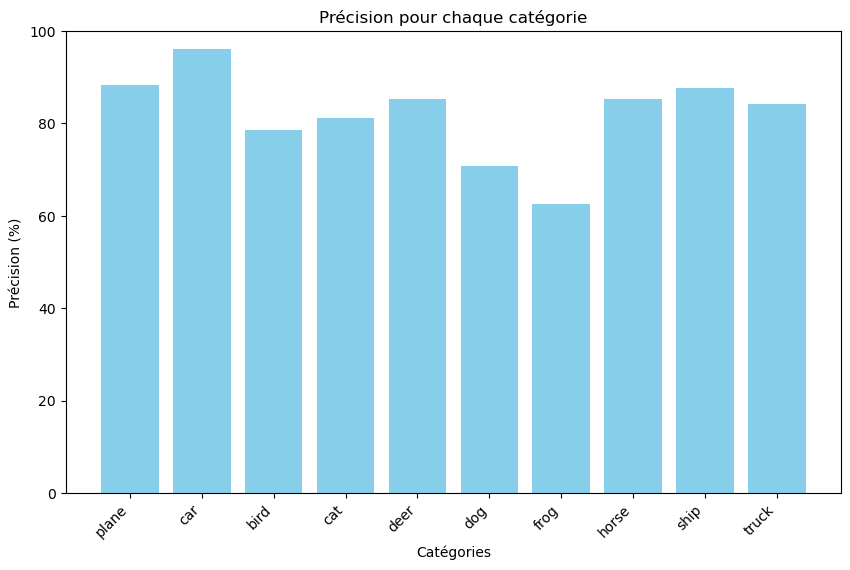

In [29]:
class_accuracies = calculate_class_accuracy(netRes, testloader, device, classes)
visualize_class_accuracies(class_accuracies)

### Evaluation ###

J'ai évalué la précision de l'étiquetage pour la reconnaissance d'images de chats. J'ai produit les trois catégories les plus probables et leurs probabilités ci-dessous.

In [30]:
def load_image(image_path, transform, device):
    image_np = mpimg.imread(image_path)
    plt.imshow(image_np)
    image_pil = transforms.ToPILImage()(image_np)
    image = transform(image_pil).unsqueeze(0).to(device)
    return image

def eval_image(image_path, transform, device):
    image = load_image(image_path, transform, device)
    with torch.no_grad():
        output = netRes(image)
        probabilities = F.softmax(output, dim=1)[0]
        max_prob, max_idx = torch.max(probabilities, dim=0)
        predicted_class_name = classes[max_idx.item()]
        print(f"Predicted class: {predicted_class_name}, Probability: {100. * max_prob.item()}%")
        top3_probs, top3_indices = torch.topk(probabilities, 3)
        for i in range(3):
            predicted_class_name = classes[top3_indices[i].item()]
            print(f"Top {i+1}: Predicted class: {predicted_class_name}, Probability: {100. * top3_probs[i].item()}%")


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Predicted class: cat, Probability: 98.04008603096008%
Top 1: Predicted class: cat, Probability: 98.04008603096008%
Top 2: Predicted class: horse, Probability: 1.0023347102105618%
Top 3: Predicted class: deer, Probability: 0.5468836519867182%


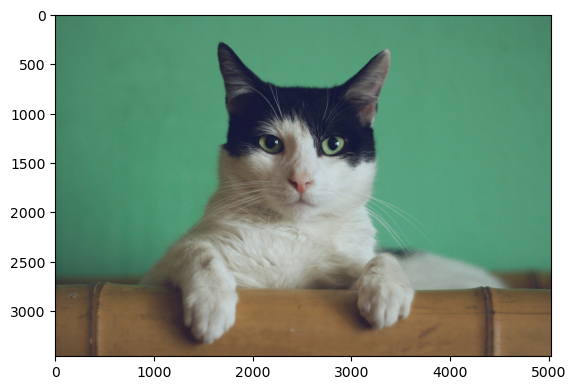

In [31]:
eval_image('cat_normal.jpg', transform, device)

Predicted class: cat, Probability: 56.64311647415161%
Top 1: Predicted class: cat, Probability: 56.64311647415161%
Top 2: Predicted class: deer, Probability: 19.650571048259735%
Top 3: Predicted class: bird, Probability: 12.4037005007267%


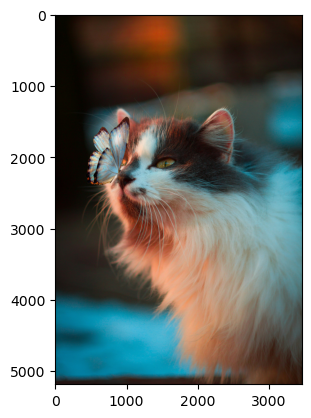

In [32]:
eval_image('cat_style.jpg', transform, device)

Lorsque l'image représente un chat classique, le modèle est capable de reconnaître la catégorie de chat, mais dès que l'image est stylisée ou contient des occlusions, la précision de la reconnaissance diminue, seulement 56.64%.

### Conclusion ###

Ce projet m'a également appris comment envisager la modification de chaque couche dans un réseau neuronal préexistant, ce qui est une compétence précieuse pour affiner et personnaliser les architectures de CNN en fonction des besoins spécifiques de chaque projet.

J'ai approfondi ma compréhension des différentes architectures de CNN et de leur impact sur les performances du modèle, ainsi qu'à sélectionner celui qui convient le mieux à une tâche spécifique en fonction des exigences en termes de précision, de temps d'entraînement et de coût de calcul.

J'ai exploré plusieurs variantes de CNN en ajustant notamment les ResidualBlocks, les hyperparamètres tels que la fonction de perte, la taille des lots (batch size) et le weight decay. Ces ajustements se sont avérés cruciaux pour améliorer les performances de mes modèles. De plus, j'ai réalisé des analyses par catégories en visualisant les probabilités par apprentissage automatique, ce qui m'a permis de visualiser la prédiction de chaque modèle dans la classification des différentes catégories d'images.

Enfin, j'ai évalué la performance de mon modèle en utilisant des images aléatoires, ce qui m'a permis de valider l'efficacité de mon modèle dans des scénarios réels.

En résumé, cette étude m'a fourni des insights précieux sur les performances des CNN dans la classification d'images et m'a permis de déterminer les meilleures pratiques pour optimiser ces modèles pour des tâches spécifiques. Ces connaissances sont essentielles pour développer des systèmes de vision par ordinateur performants dans divers domaines d'application.

Auteur : Ziyi WANG